# Churn Analysis

In [1]:
# Import Packages
import pandas as pd
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
import seaborn as sns

import math
from datetime import datetime, timedelta

#import scikit-learn
#import jupyterlab
#import xgboost

# Set Display Preferences
pd.set_option('display.max_columns', None)
pd.options.display.float_format = "{:.2f}".format

### Load & remove duplicates

In [2]:
### UK Based ecom retailer sales from Jan 12, 2009 to Sep 12, 2011.
### Mainly sells unique all-occasion gift-ware.
df1 = pd.read_excel("data/online_retail_II.xlsx", sheet_name='Year 2009-2010', header=0)
df2 = pd.read_excel("data/online_retail_II.xlsx", sheet_name='Year 2010-2011', header=0)

### Note: Both excel sheets contain 2010 sales. Duplicates must be removed before concatenating.
# There is 1 week of overlap in the datasets
print(df1['InvoiceDate'].max())
print(df2['InvoiceDate'].min())

# Remove duplicate entries 
df1 = df1[~df1["Invoice"].isin(df2['Invoice'].unique())]
# Note: achives identical result as -> df1[df1['InvoiceDate']<df2['InvoiceDate'].min()] 

2010-12-09 20:01:00
2010-12-01 08:26:00


### Define new factors

In [3]:
### Merge the dataframes from each year
df = pd.concat([df1, df2], axis=0, ignore_index=True)

### Create a Invoice Amount column
df['Invoice Amount'] = df['Price'] * df['Quantity']

### Sales are overwhelmingly from the UK.
uk_pct = len(df[df['Country']=='United Kingdom']) / len(df)
print(f'Percent of entries sold in the UK: {uk_pct*100:.2f}%')
# Create a binary variable indicating UK vs. Global.
df['UK_Ind'] = np.where(df['Country']=='United Kingdom', 1, 0)

### Remove time component from Invoice Date
df['InvoiceDate'] = df['InvoiceDate'].dt.date

df_orig = df.copy()

Percent of entries sold in the UK: 91.88%


### Remove appropriate invoice entries

In [4]:
### Null Customer IDs (required to determine churn). 
### Reason for missing Customer ID is unknown. For simplicity, these entries will be excluded from the analysis. This likely creates a source of bias.
### Recomendation is to update the ordering platform to require purchasers to create an account, generating a unique Customer ID.
null_id_pct = sum(df['Customer ID'].isnull()) / len(df)
print(f'Percent of entries that are missing Customer ID: {null_id_pct*100:.2f}%')


### Some items have a price of $0. These entries will not count towards orders.
### Primarily consisting of car flags, stickers, shipping materials & invoice notes.
non_items = len(df[df['Price']==0]) / len(df)
print(f'Percent of entries that had a price of $0: {non_items*100:.2f}%')


### Examining the Stock Codes, entries starting with alphabetic characters are atypical invoice entries that do not represent merchandise sales.
### Ex. Test products, adjustments, postage, carriage, etc.
df["StockCode"] = df["StockCode"].astype(str)
stockcode = (
    df.groupby(["StockCode", "Description"])["Quantity"]
      .sum()
      .reset_index()        
      .sort_values("StockCode", ascending=False)
    )

stockcode_pct = sum(~df['StockCode'].str.match(r'^\d')) / len(df)
print(f'Percent of entries that have invalid Stock Codes: {stockcode_pct*100:.2f}%')


### Remove entries is no Customer ID or Price = $0
df = df[~df['Customer ID'].isnull()]
df = df[df['Price']!=0]
### Remove entries for Stock Codes beginning with alphabetic characters
df = df[df['StockCode'].str.match(r'^\d')]

Percent of entries that are missing Customer ID: 22.52%
Percent of entries that had a price of $0: 0.58%
Percent of entries that have invalid Stock Codes: 0.57%


### Aggregate data to Customer ID granualrity

In [5]:
def aggregate_by_cx(df):
    """
    Aggregate transaction data & group it by Customer ID
    """
    df = df.reset_index()
    df_aggregated = df.groupby(['Customer ID', 'UK_Ind'], as_index=False).agg(
        # First & last txn in the measurement period
        first_txn = ('InvoiceDate', 'min'),
        last_txn = ('InvoiceDate', 'max'),
        # Transaction Count
        total_txns = ('Invoice', 'nunique'),
        sale_txns = ('Invoice', lambda x: x[df.loc[x.index, 'Quantity'] >= 0].nunique()),
        return_txns = ('Invoice', lambda x: x[df.loc[x.index, 'Quantity'] < 0].nunique()),
        # Sales amount ($)
        total_amt = ('Invoice Amount', 'sum'),
        sale_amt = ('Invoice Amount', lambda x: x[df.loc[x.index, 'Quantity'] >= 0].sum()),
        return_amt = ('Invoice Amount', lambda x: x[df.loc[x.index, 'Quantity'] < 0].sum()),
        # Sale quantity
        total_qty = ('Quantity', 'sum'),
        sale_qty = ('Quantity', lambda x: x[df.loc[x.index, 'Quantity'] >= 0].sum()),
        return_qty = ('Quantity', lambda x: x[df.loc[x.index, 'Quantity'] < 0].sum()),
        # Variaty of SKUs
        total_skus = ('StockCode', 'nunique'),
        sale_skus = ('StockCode', lambda x: x[df.loc[x.index, 'Quantity'] >= 0].nunique())
        )

    # Returns Percent
    df_aggregated['return_pct'] = -1*df_aggregated['return_amt'] / (-1*df_aggregated['return_amt'] + df_aggregated['sale_amt'])
    # Units per Transaction
    df_aggregated['upt'] = df_aggregated['total_qty'] / df_aggregated['total_txns']
    # Average Unit Retail
    #df_aggregated['aur'] = df_aggregated['total_amt'] / df_aggregated['total_qty']           ### Issues with div by 0
    # Average Order Value
    df_aggregated['aov'] = df_aggregated['total_amt'] / df_aggregated['total_txns']
    
    return df_aggregated

In [6]:
### Check to confirm there are no Customer IDs found in multiple markets/countries
df_aggregated = aggregate_by_cx(df)
cx_market = df_aggregated.groupby("Customer ID")["UK_Ind"].count()
multi_market_cx = sum(cx_market>1)
print('Number of customers in multiple markets:', multi_market_cx)

Number of customers in multiple markets: 0


In [7]:
### Churn will be definited by if a customer purchases in the next 180 days.
### The past 180 days will be used to train a model that predicts likelihood to churn. This will be called the observation window.
### The dataset spans 2 years, so this approach evaluates churn in a recurant sliding window approach.
observation_days = 180
observation_periods = (df['InvoiceDate'].max() - df['InvoiceDate'].min()).days / observation_days
observation_periods = int(math.floor(observation_periods))
print('Number of', observation_days, 'day periods:', observation_periods, '\n')

# Slice data by observation period starting from most recent & working backward by increments equal to the duration of the observation period
end = df['InvoiceDate'].max()
df_churn_ind = pd.DataFrame()
for i in range(observation_periods):
    # Get start & end date for the given observation period.
    period_end = end
    period_start = period_end - timedelta(observation_days)
    # Create a temporary dataframe for the observation period. Aggregate by Customer ID & compute customer satistics.
    df_i = df[df['InvoiceDate'].between(period_start,period_end)]
    df_i = aggregate_by_cx(df_i)
    
    # Tag if customer churns in next period
    if i==0:
        churn_ind = np.nan
    else:
        churn_ind = df_i['Customer ID'].isin(df_next_period['Customer ID']).map({True: 0, False: 1})
    # Define new columns for Churn Indicator & Observation Period
    df_i.insert(loc=0, column='churn_ind', value=churn_ind)
    df_i.insert(loc=0, column='Period', value=observation_periods-i)
    df_i.insert(loc=0, column='Observation End', value=period_end)
    df_i.insert(loc=0, column='Observation Start', value=period_start)

    # Concatenate each period's customer data into a single dataframe
    df_churn_ind = pd.concat([df_churn_ind, df_i], ignore_index=True)

    # Updated end date for next period
    df_next_period = df_i.copy()
    end = period_start - timedelta(days=1)

df_churn_ind = df_churn_ind.sort_values(by=['Customer ID', 'Observation Start'],ignore_index=True)


Number of 180 day periods: 4 



## EDA

In [15]:
df_churn_ind.sort_values(by='total_amt',ascending=False).iloc[0,:]

Observation Start    2010-06-15
Observation End      2010-12-12
Period                        2
churn_ind                  0.00
Customer ID            18102.00
UK_Ind                        1
first_txn            2010-06-23
last_txn             2010-12-09
total_txns                   42
sale_txns                    41
return_txns                   1
total_amt             182419.78
sale_amt              183702.18
return_amt             -1282.40
total_qty                 52155
sale_qty                  52435
return_qty                 -280
total_skus                  128
sale_skus                   128
return_pct                 0.01
upt                     1241.79
aov                     4343.33
Name: 11986, dtype: object

In [41]:
x

0         27.05
1        142.31
2          0.00
3       1323.32
4       1494.16
          ...  
12347    725.48
12348   1071.61
12349   1224.10
12350    765.28
12351   1072.00
Name: total_amt, Length: 12352, dtype: float64

In [43]:
#x = df_churn_ind[df_churn_ind['total_amt']>50000]

x = df_churn_ind['total_amt'].clip(lower=df_churn_ind['total_amt'].quantile(0.01),   
                                       upper=df_churn_ind['total_amt'].quantile(0.99))


plt.figure(figsize=(8, 6))
sns.histplot(x['total_amt'], kde=True)
plt.title('var')

plt.tight_layout()
plt.show()

KeyError: 'total_amt'

<Figure size 800x600 with 0 Axes>

In [8]:
df_churn = df_churn_ind[df_churn_ind['Period']<observation_periods]
df_churn.columns

Index(['Observation Start', 'Observation End', 'Period', 'churn_ind',
       'Customer ID', 'UK_Ind', 'first_txn', 'last_txn', 'total_txns',
       'sale_txns', 'return_txns', 'total_amt', 'sale_amt', 'return_amt',
       'total_qty', 'sale_qty', 'return_qty', 'total_skus', 'sale_skus',
       'return_pct', 'upt', 'aov'],
      dtype='object')

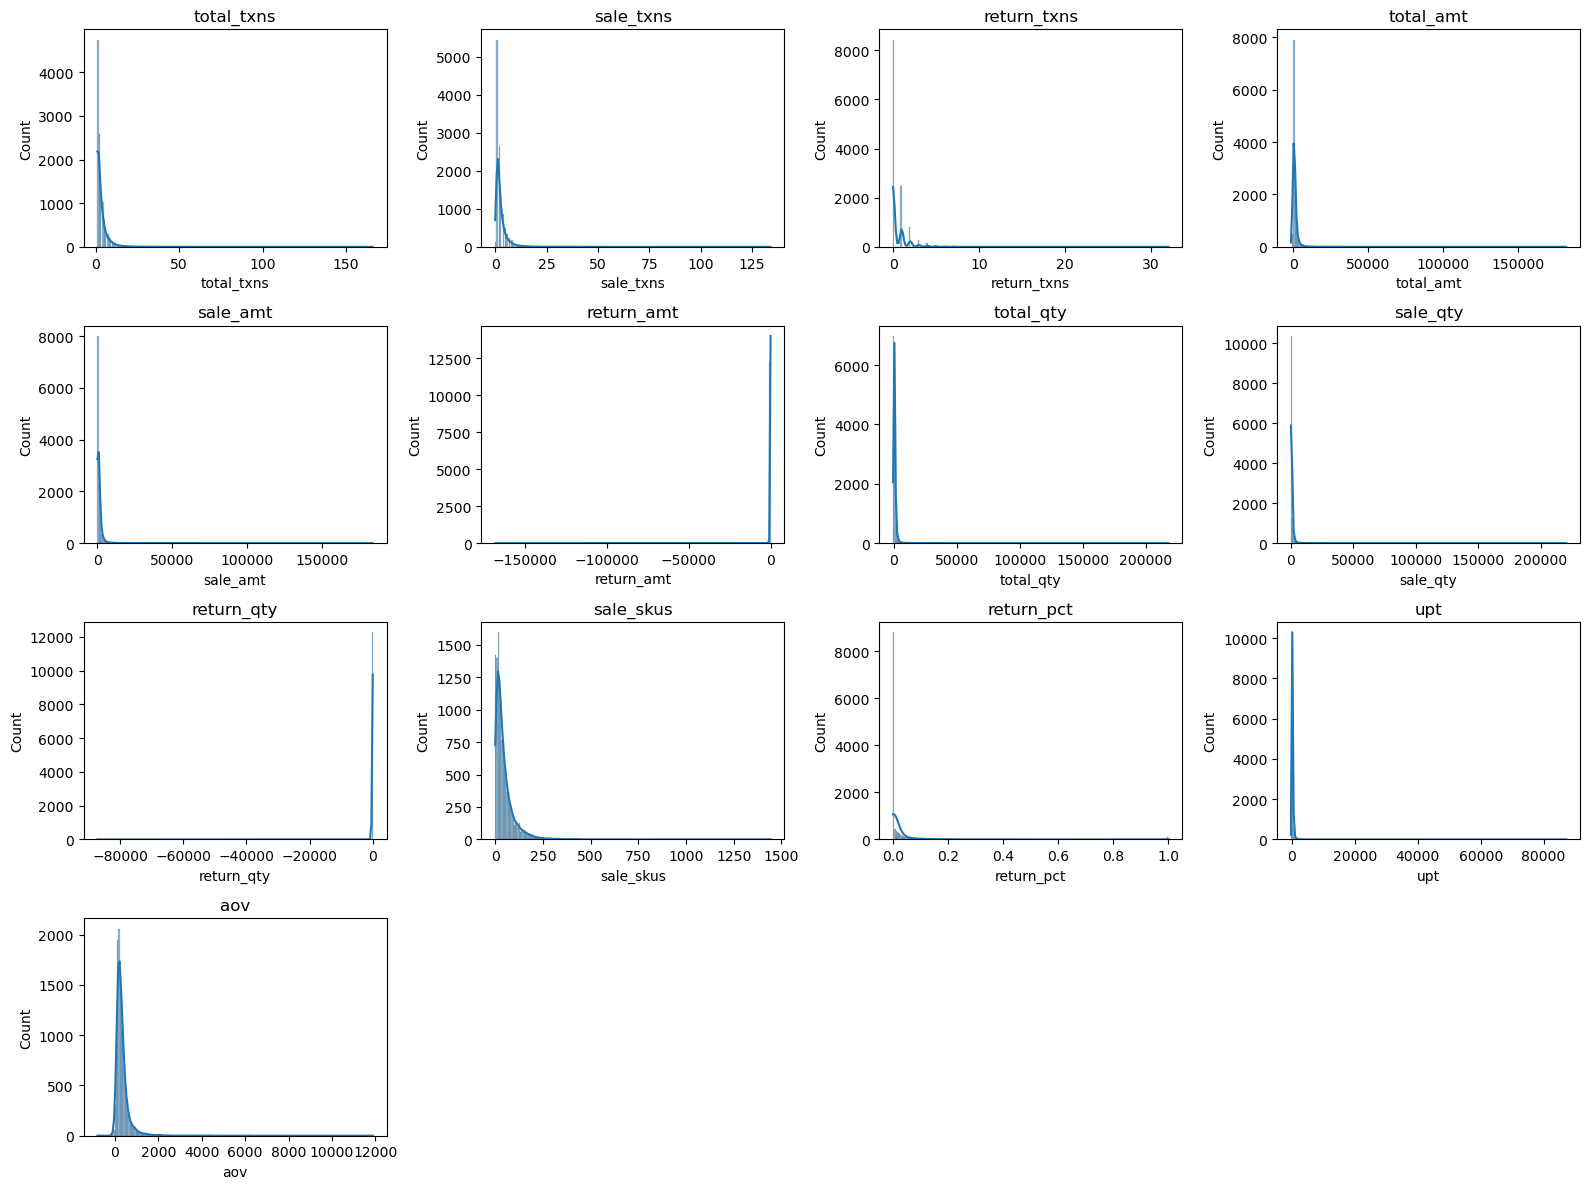

In [9]:
### Distribution of key variable
key_vars = ['total_txns',
       'sale_txns', 'return_txns', 'total_amt', 'sale_amt', 'return_amt',
       'total_qty', 'sale_qty', 'return_qty', 'sale_skus',
       'return_pct', 'upt', 'aov']

plt.figure(figsize=(16, 12))
for i, col in enumerate(key_vars, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df_churn_ind[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

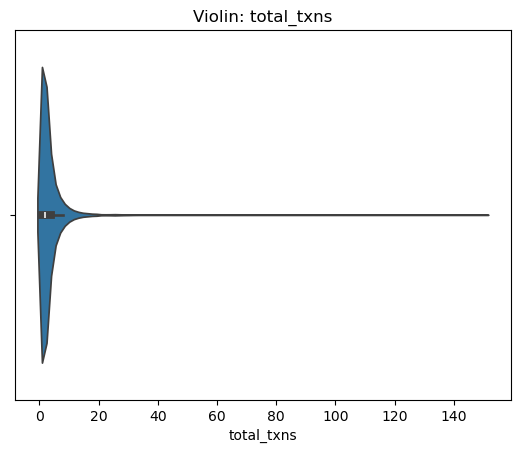

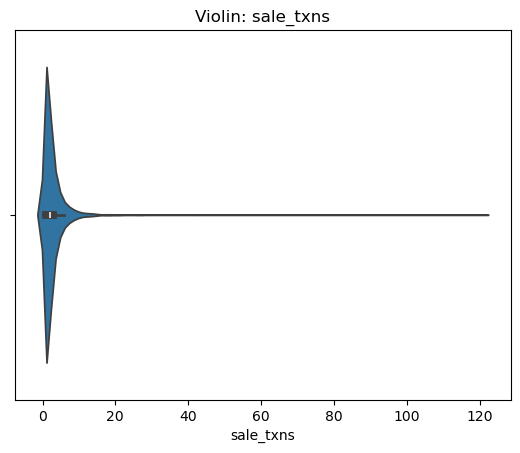

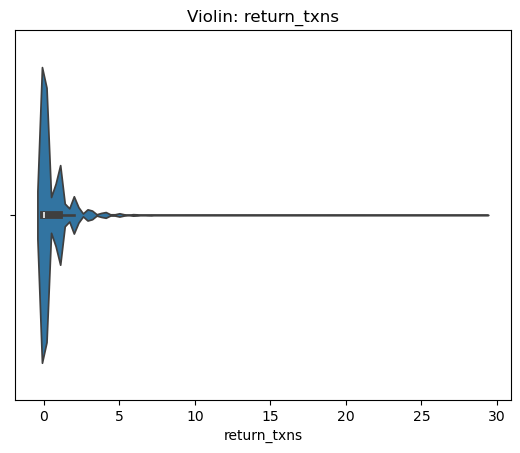

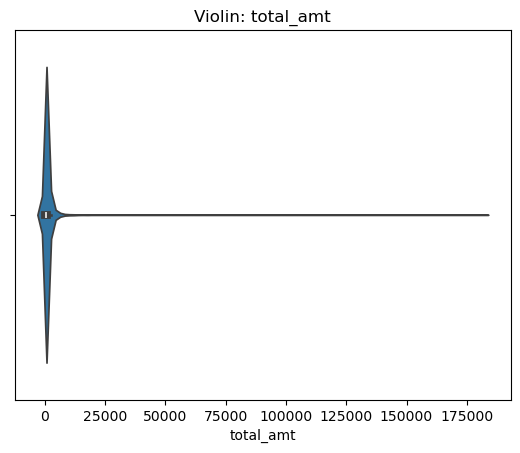

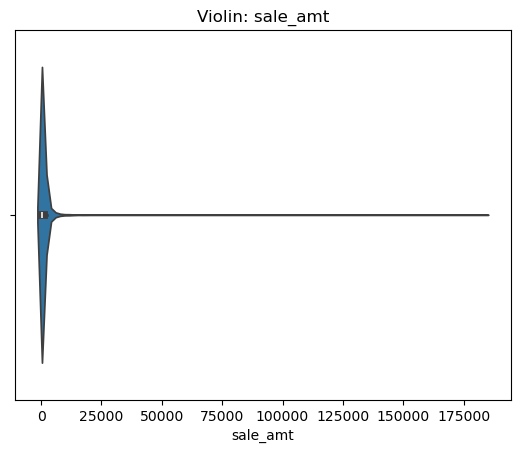

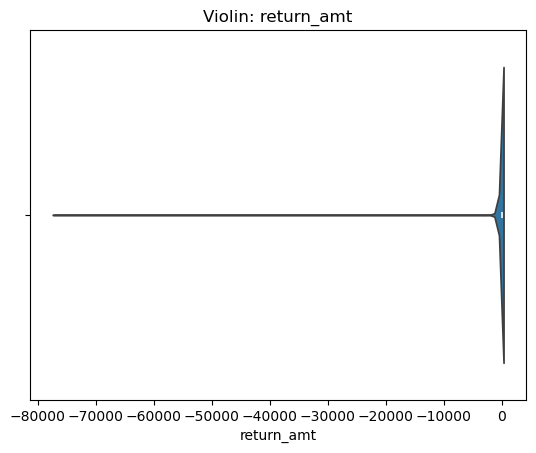

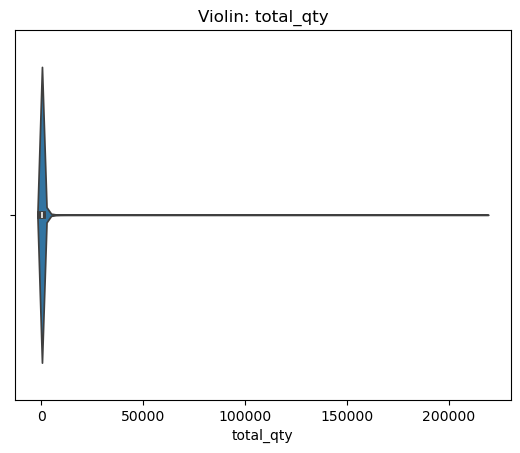

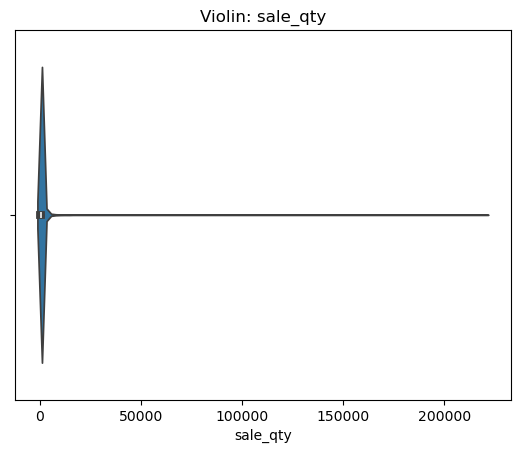

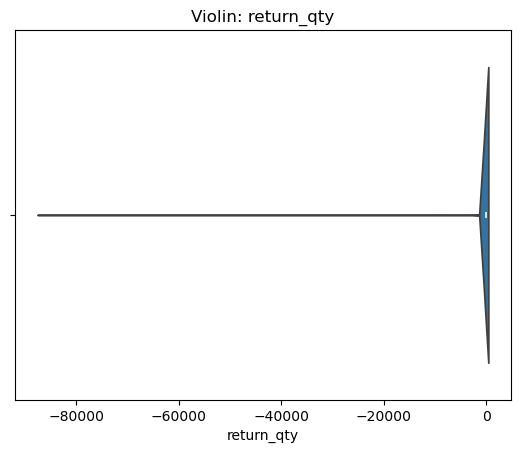

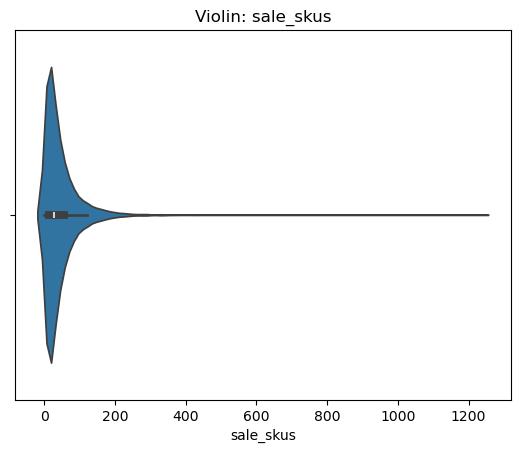

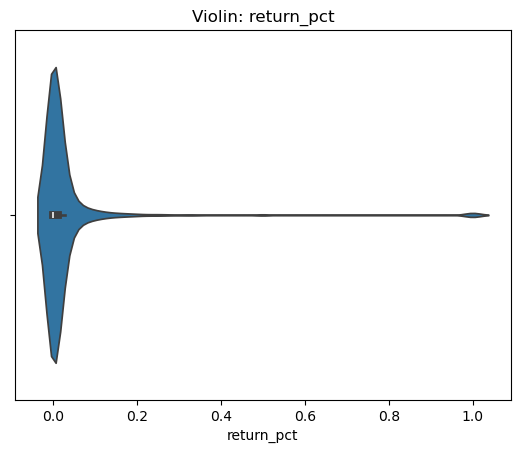

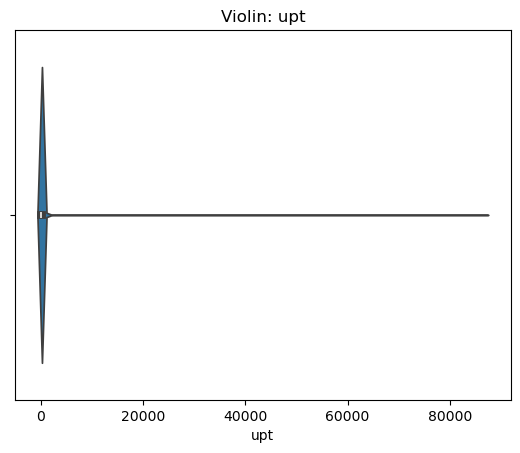

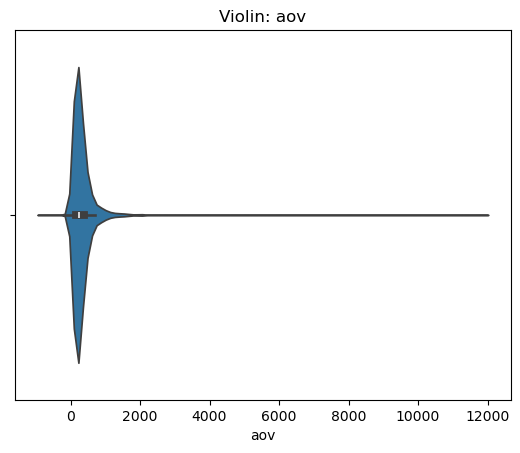

In [10]:
for col in key_vars:
    sns.violinplot(x=df_churn[col])
    plt.title(f"Violin: {col}")
    plt.show()


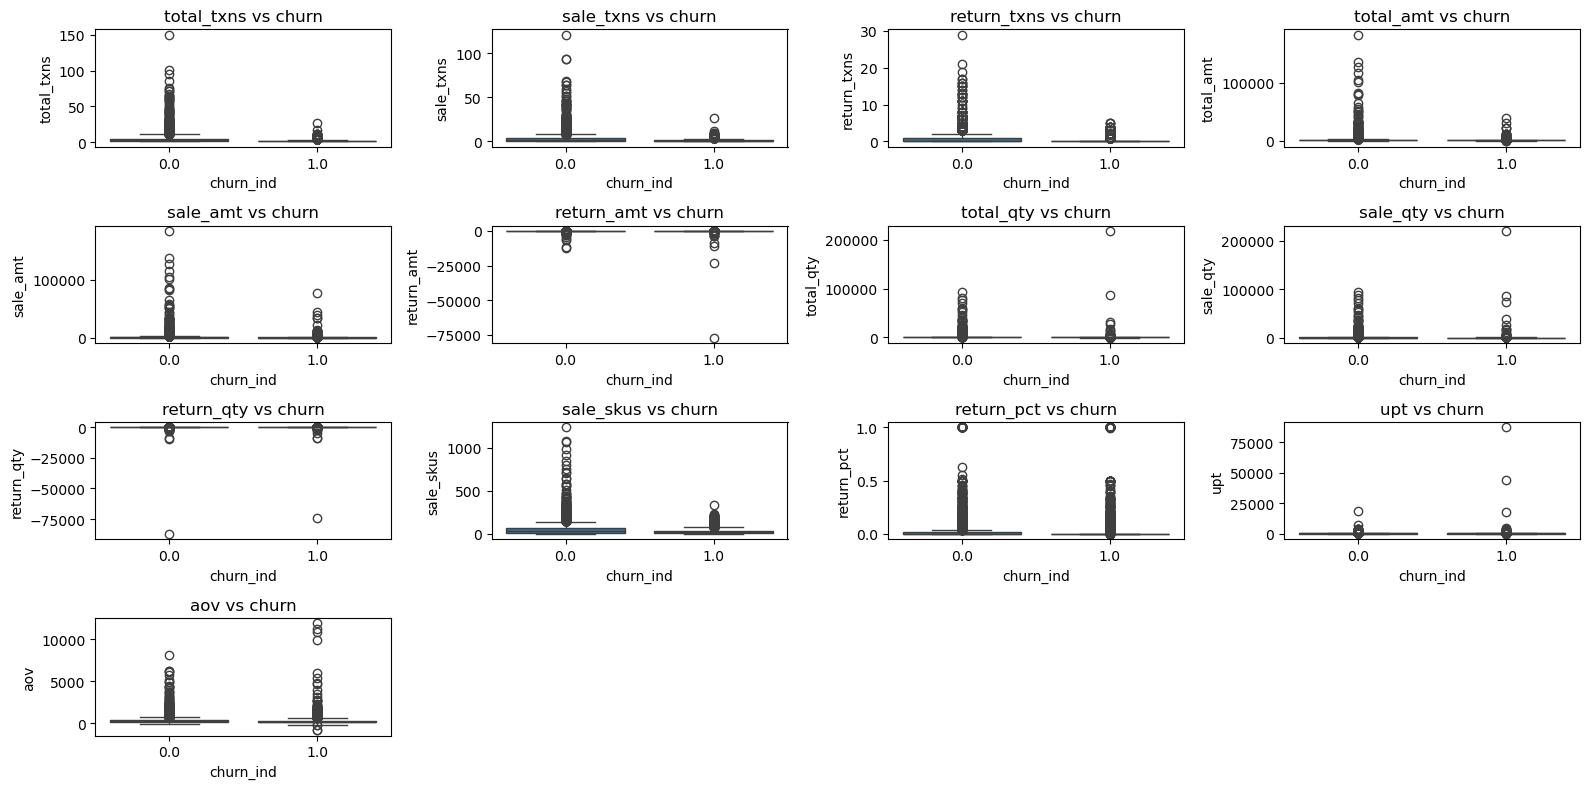

In [11]:
### Input replationships with churn
plt.figure(figsize=(16, 8))
for i, col in enumerate(key_vars, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x="churn_ind", y=col, data=df_churn)
    plt.title(f"{col} vs churn")
plt.tight_layout()
plt.show()

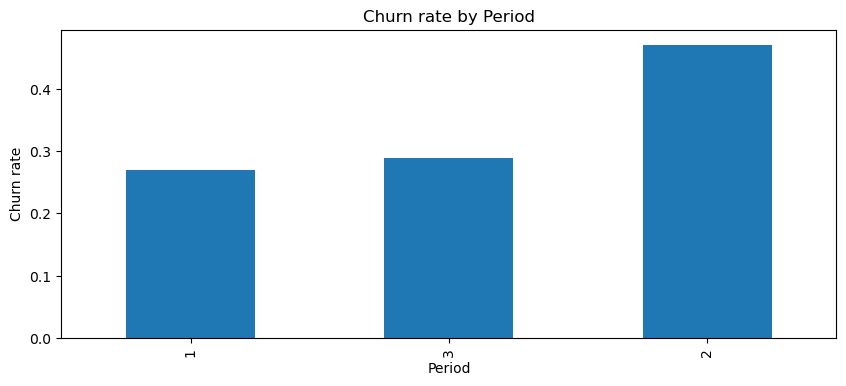

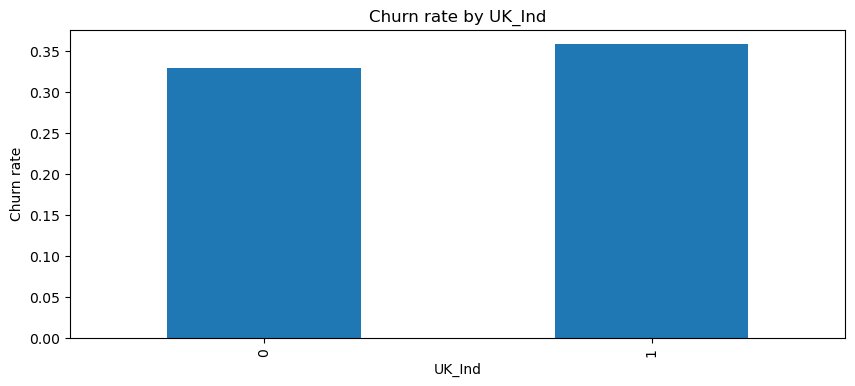

In [13]:
#df_churn['Period'] = df_churn['Period'].astype('category')
cat_vars = ["Period", "UK_Ind"]

for col in cat_vars:
    churn_rate = df_churn.groupby(col)["churn_ind"].mean().sort_values()
    churn_rate.plot(kind='bar', figsize=(10,4), title=f"Churn rate by {col}")
    plt.ylabel("Churn rate")
    plt.show()

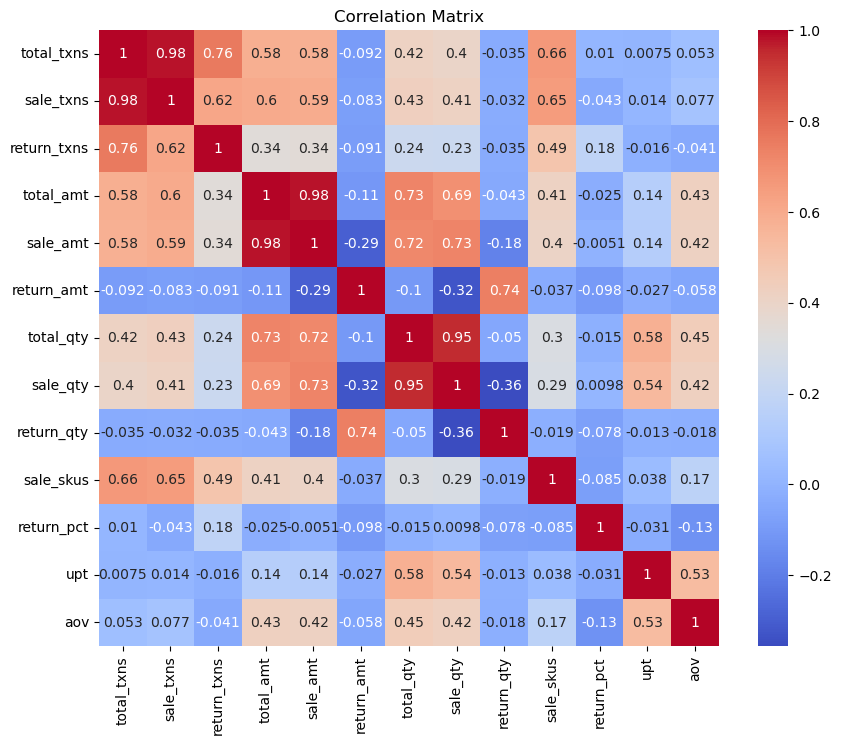

In [14]:
### Multicolinearity
plt.figure(figsize=(10, 8))
sns.heatmap(df_churn[key_vars].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [15]:
### Outlier visualization

KeyError: 'Churn Next Period'

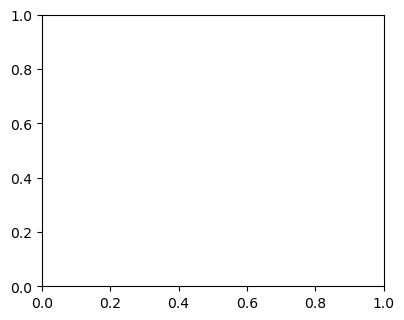

In [ ]:
import seaborn as sns

df_churn = df_churn_ind[df_churn_ind['Period']!=4]

target = "Churn Next Period"
features = ['total_txns', 'total_amt', 'sale_amt', 'total_skus', 'return_pct', 'upt', 'aov']

# compute grid size automatically
n = len(features)
cols = 4
rows = math.ceil(n / cols)

plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=df_churn[target], y=df_churn[col])
    plt.title(col)

plt.tight_layout()
plt.show()

### Placeholder

In [ ]:
#35% churn 180 days

#42% churn 90 days
df_churn_ind 

In [ ]:
dft = df_churn_ind.copy()
#dft.drop(['aur', 'aov', 'return_pct', 'upt'], axis=1, inplace=True)


# Convert churn to binary
dft['churn'] = dft['Churn Next Period'].map({'yes': 1, 'no': 0})

# Keep only rows where churn is defined (Periods 1–3)
dft = dft[dft['Period'] < observation_periods]

# Train = Periods 1 and 2
train_df = dft[dft['Period'] < observation_periods-1].copy()

# Test = Period 3 (most recent labeled period)
test_df = dft[dft['Period'] == observation_periods-1].copy()


# Clean target leakage
drop_cols = [
    'Observation Start', 'Observation End',
    'Period', 'Churn Next Period', 'Customer ID',
    'first_txn', 'last_txn'
]

X_train = train_df.drop(columns=drop_cols + ['churn'])
y_train = train_df['churn']

X_test = test_df.drop(columns=drop_cols + ['churn'])
y_test = test_df['churn']

# Fill missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Scale for Logistic Regression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## fit logistic regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]


## Fit gradiant boost
from xgboost import XGBClassifier

gb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]



## evaluate both
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate(y_true, y_pred, y_prob, model_name):
    print(f"\n=== {model_name} ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_true, y_prob))

evaluate(y_test, y_pred_lr, y_prob_lr, "Logistic Regression")
evaluate(y_test, y_pred_gb, y_prob_gb, "Gradient Boosting (XGBoost)")

